In [1]:
import os
import numpy as np
import trimesh
import torch
from torchvision.transforms import (ToPILImage, GaussianBlur)

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
from pytorch3d.loss import (
    chamfer_distance,    
)

from src.render.mesh_face_renderer import MeshFaceRenderer
from src.utilities.polar_traversal import (
    scale_mesh, 
    flip_mesh,
)
from src.utilities.polar_traversal import gather_all_paths, sample_all_paths
from src.utilities.util import grid_to_list
from src.utilities.alignment import align
from src.augment.geoaug import GeoAugment
from src.config import get_parser

In [2]:
config = get_parser().parse_args(args=[])   

config.fast_image_size = 512
config.raster_faces_per_pixel = 4
config.lights_direction = [0.0, 0.0, 3.0]
config.specular_color = [0.15, 0.15, 0.15]
config.viewpoint_distance = 1.0
R = MeshFaceRenderer(config)
device = torch.device('cuda')

torch.Size([1, 1, 512, 512])


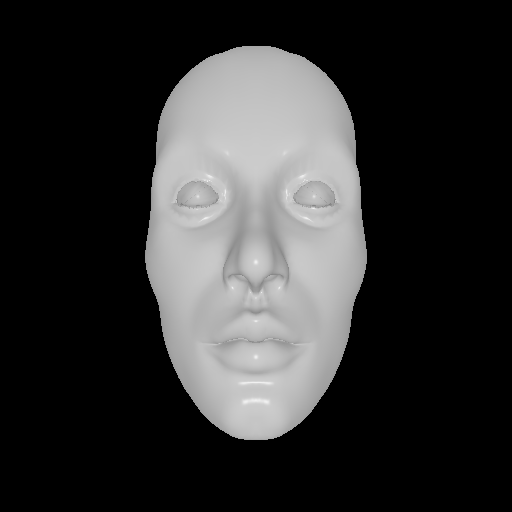

In [3]:
mesh  = flip_mesh(scale_mesh('./data/female_face.stl', offset=-0.20))
vertices = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]
normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
verts, ts = GeoAugment(vertices, config.geoaug_policy)
verts = verts[None]
t_points, t_normals = align(verts, normals)
renders =  R(t_points, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

In [4]:
meshes = Meshes(verts=verts, faces=faces)
meshes

In [5]:
num_samples = 256**2
samples = sample_points_from_meshes(meshes, num_samples=num_samples)[0]
samples.shape

torch.Size([65536, 3])

In [6]:
stl_root = './data/stl_mesh/'
stl_files = os.listdir(stl_root)
stl_files.sort()
stl_files

['abe_white_inpatient.stl',
 'abigaile_ortiz_tomb_raider.stl',
 'ada_wong_resident_evil.stl',
 'administrator_evil_within.stl',
 'aidan_overkill_walking_dead.stl',
 'amelia_croft_tomb_raider.stl',
 'anakin_skywalker_battlefront_2.stl',
 'angela_civilian_detroit.stl',
 'annie_dead_rising.stl',
 'anya_gears_of_war.stl',
 'aphrodite_ascendant_one.stl',
 'aranea_highwind_final_fantasy.stl',
 'ares_ascendant_one.stl',
 'artemis_ascendant_one.stl',
 'athena_ascendant_one.stl',
 'badgirl_no_more_heroes.stl',
 'badman_no_more_heroes.stl',
 'becky_hidden_agenda.stl',
 'black_lightning_injustice_2.stl',
 'bridger_overkill_walking_dead.stl',
 'caligo_ulldor_final_fantasy.stl',
 'camelia_claustra_final_fantasy.stl',
 'cameron_burke_far_cry.stl',
 'carl_detroit.stl',
 'cassie_drake_uncharted.stl',
 'catherine_hidden_agenda.stl',
 'chloe_detroit.stl',
 'cid_sophiar_final_fantasy.stl',
 'cindy_aurum_final_fantasy.stl',
 'claire_resident_evil.stl',
 'clara_odea_assassins_creed.stl',
 'connor_detroit.s

In [7]:
def get_stl(file_path):
    mesh  = flip_mesh(scale_mesh(file_path, offset=-0.20))
    vertices = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
    verts, ts = GeoAugment(vertices, config.geoaug_policy)
    verts = verts[None]
    t_points, t_normals = align(verts, normals)
    return t_points, t_normals, faces
   

In [8]:
num_samples = 256**2

latitudes_num = 1024
samples_num = 256

renders_root = './data/augmented/renders'
samples_root = './data/augmented/samples'
#aug_stls_root = './data/augmented/stls'
stl_grid_root = './data/stl_grid/'
save_grid_root = './data/augmented/grid/'
R = MeshFaceRenderer(config)
for i, stl_file in enumerate(stl_files):
    print(i, stl_file)
    file_path = os.path.join(stl_root, stl_file)
    print(file_path)
    mesh  = flip_mesh(scale_mesh(file_path, offset=-0.20))
    vertices = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
    
    for i in range(100):
        verts, ts = GeoAugment(vertices, config.geoaug_policy)        
        verts = verts[None]
        vert, normals = align(verts, normals, rotate=False)    

        renders =  R(vert, faces, device)    
        img = ToPILImage()(renders[0])
        stl_name = stl_file.replace('.stl', '')
        render_dir =  os.path.join(renders_root, stl_name)
        if not os.path.exists(render_dir):
            os.makedirs(render_dir)
        infix = str(i).zfill(5)
        img.save(os.path.join(render_dir, stl_name + f'_{infix}.png'))

        samples_dir = os.path.join(samples_root, stl_name)
        if not os.path.exists(samples_dir):
            os.makedirs(samples_dir)

        meshes = Meshes(verts=verts.cpu(), faces=faces.cpu())
        samples = sample_points_from_meshes(meshes, num_samples=num_samples)[0]
        torch.save(samples, os.path.join(samples_dir, stl_name +  f'_{infix}.pth'))
        
        grid_file = os.path.join(stl_grid_root, f'{stl_name}_256.pth')
        grid_vertices = torch.load(grid_file)['vertices']
        grid_vertices = grid_to_list(grid_vertices[None])[0]
        verts, ts = GeoAugment(grid_vertices, config.geoaug_policy)   
        grid_save_dir = os.path.join(save_grid_root, stl_name) #  + 
        if not os.path.exists(grid_save_dir):
            os.makedirs(grid_save_dir)
        grid_save_file = os.path.join(grid_save_dir, f'{stl_name}_{infix}.pth')
        print(grid_save_file)
        torch.save(verts, grid_save_file)
#         aug_stl_file = os.path.join(aug_stls_root, stl_name + str(hash(str(ts))) + '.stl')
#         t_mesh = trimesh.Trimesh(vertices=verts[0].cpu(), faces=faces[0].cpu())
#         t_mesh.export(aug_stl_file)
        
#         paths = gather_all_paths(aug_stl_file, latitudes_num)
#         grid_samples = sample_all_paths(paths, samples_num)
#         break
#         grid_samples_file = aug_stl_file.replace('.stl', '.pth')
#         torch.save(grid_samples, grid_samples_file)
    
        

0 abe_white_inpatient.stl
./data/stl_mesh/abe_white_inpatient.stl
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00000.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00001.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00002.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00003.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00004.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00005.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00006.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00007.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00008.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00009.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00010.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00011.pth
./data/augmented/grid/abe_white_inpatient/abe_white_inpatient_00012.pt

./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00012.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00013.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00014.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00015.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00016.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00017.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00018.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00019.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00020.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00021.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abigaile_ortiz_tomb_raider_00022.pth
./data/augmented/grid/abigaile_ortiz_tomb_raider/abiga

./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00009.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00010.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00011.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00012.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00013.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00014.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00015.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00016.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00017.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00018.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00019.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_evil_00020.pth
./data/augmented/grid/ada_wong_resident_evil/ada_wong_resident_e

./data/augmented/grid/administrator_evil_within/administrator_evil_within_00016.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00017.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00018.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00019.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00020.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00021.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00022.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00023.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00024.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00025.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00026.pth
./data/augmented/grid/administrator_evil_within/administrator_evil_within_00

./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00012.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00013.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00014.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00015.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00016.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00017.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00018.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00019.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00020.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00021.pth
./data/augmented/grid/aidan_overkill_walking_dead/aidan_overkill_walking_dead_00022.pth
./data/augmented/grid/aidan_over

./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00008.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00009.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00010.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00011.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00012.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00013.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00014.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00015.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00016.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00017.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00018.pth
./data/augmented/grid/amelia_croft_tomb_raider/amelia_croft_tomb_raider_00019.pth
./data/augmented

./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00008.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00009.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00010.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00011.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00012.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00013.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00014.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00015.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00016.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00017.pth
./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_

./data/augmented/grid/anakin_skywalker_battlefront_2/anakin_skywalker_battlefront_2_00099.pth
7 angela_civilian_detroit.stl
./data/stl_mesh/angela_civilian_detroit.stl
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00000.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00001.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00002.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00003.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00004.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00005.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00006.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00007.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00008.pth
./data/augmented/grid/angela_civilian_detroit/angela_civilian_detroit_00009.pth
./data/augmented/grid/angela_civ

./data/augmented/grid/annie_dead_rising/annie_dead_rising_00000.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00001.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00002.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00003.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00004.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00005.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00006.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00007.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00008.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00009.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00010.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00011.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00012.pth
./data/augmented/grid/annie_dead_rising/annie_dead_rising_00013.pth
./data/augmented/grid/annie_dead_rising/annie_de

./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00020.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00021.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00022.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00023.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00024.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00025.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00026.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00027.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00028.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00029.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00030.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00031.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00032.pth
./data/augmented/grid/anya_gears_of_war/anya_gears_of_war_00033.pth
./data/augmented/grid/anya_gears_of_war/anya_gea

./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00036.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00037.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00038.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00039.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00040.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00041.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00042.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00043.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00044.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00045.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00046.pth
./data/augmented/grid/aphrodite_ascendant_one/aphrodite_ascendant_one_00047.pth
./data/augmented/grid/aphrodite_ascendan

./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00034.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00035.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00036.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00037.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00038.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00039.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00040.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00041.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00042.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantasy_00043.pth
./data/augmented/grid/aranea_highwind_final_fantasy/aranea_highwind_final_fantas

./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00030.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00031.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00032.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00033.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00034.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00035.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00036.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00037.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00038.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00039.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00040.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00041.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00042.pth
./data/augmented/grid/ares_ascendant_one/ares_ascendant_one_00043.pth
./data/augmented/gri

./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00046.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00047.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00048.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00049.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00050.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00051.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00052.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00053.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00054.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00055.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00056.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00057.pth
./data/augmented/grid/artemis_ascendant_one/artemis_ascendant_one_00058.pth
./data/augme

./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00056.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00057.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00058.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00059.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00060.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00061.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00062.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00063.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00064.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00065.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00066.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00067.pth
./data/augmented/grid/athena_ascendant_one/athena_ascendant_one_00068.pth
./data/augmented/grid/athena_ascendant

./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00064.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00065.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00066.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00067.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00068.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00069.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00070.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00071.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00072.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00073.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00074.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_heroes_00075.pth
./data/augmented/grid/badgirl_no_more_heroes/badgirl_no_more_her

./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00070.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00071.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00072.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00073.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00074.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00075.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00076.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00077.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00078.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00079.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00080.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00081.pth
./data/augmented/grid/badman_no_more_heroes/badman_no_more_heroes_00082.pth
./data/augme

./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00082.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00083.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00084.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00085.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00086.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00087.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00088.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00089.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00090.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00091.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00092.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00093.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00094.pth
./data/augmented/grid/becky_hidden_agenda/becky_hidden_agenda_00

./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00078.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00079.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00080.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00081.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00082.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00083.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00084.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00085.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00086.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00087.pth
./data/augmented/grid/black_lightning_injustice_2/black_lightning_injustice_2_00088.pth
./data/augmented/grid/black_ligh

./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00068.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00069.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00070.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00071.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00072.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00073.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00074.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00075.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00076.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dead_00077.pth
./data/augmented/grid/bridger_overkill_walking_dead/bridger_overkill_walking_dea

./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00059.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00060.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00061.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00062.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00063.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00064.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00065.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00066.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00067.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00068.pth
./data/augmented/grid/caligo_ulldor_final_fantasy/caligo_ulldor_final_fantasy_00069.pth
./data/augmented/grid/caligo_ull

./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00049.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00050.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00051.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00052.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00053.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00054.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00055.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00056.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00057.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia_claustra_final_fantasy_00058.pth
./data/augmented/grid/camelia_claustra_final_fantasy/camelia

./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00044.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00045.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00046.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00047.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00048.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00049.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00050.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00051.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00052.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00053.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00054.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00055.pth
./data/augmented/grid/cameron_burke_far_cry/cameron_burke_far_cry_00056.pth
./data/augme

./data/augmented/grid/carl_detroit/carl_detroit_00068.pth
./data/augmented/grid/carl_detroit/carl_detroit_00069.pth
./data/augmented/grid/carl_detroit/carl_detroit_00070.pth
./data/augmented/grid/carl_detroit/carl_detroit_00071.pth
./data/augmented/grid/carl_detroit/carl_detroit_00072.pth
./data/augmented/grid/carl_detroit/carl_detroit_00073.pth
./data/augmented/grid/carl_detroit/carl_detroit_00074.pth
./data/augmented/grid/carl_detroit/carl_detroit_00075.pth
./data/augmented/grid/carl_detroit/carl_detroit_00076.pth
./data/augmented/grid/carl_detroit/carl_detroit_00077.pth
./data/augmented/grid/carl_detroit/carl_detroit_00078.pth
./data/augmented/grid/carl_detroit/carl_detroit_00079.pth
./data/augmented/grid/carl_detroit/carl_detroit_00080.pth
./data/augmented/grid/carl_detroit/carl_detroit_00081.pth
./data/augmented/grid/carl_detroit/carl_detroit_00082.pth
./data/augmented/grid/carl_detroit/carl_detroit_00083.pth
./data/augmented/grid/carl_detroit/carl_detroit_00084.pth
./data/augment

./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00082.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00083.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00084.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00085.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00086.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00087.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00088.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00089.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00090.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00091.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00092.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_uncharted_00093.pth
./data/augmented/grid/cassie_drake_uncharted/cassie_drake_unchar

./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00084.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00085.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00086.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00087.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00088.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00089.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00090.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00091.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00092.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00093.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00094.pth
./data/augmented/grid/catherine_hidden_agenda/catherine_hidden_agenda_00095.pth
./data/augmented/grid/catherine_hidden_a

./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00010.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00011.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00012.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00013.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00014.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00015.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00016.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00017.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00018.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00019.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00020.pth
./data/augmented/grid/cid_sophiar_final_fantasy/cid_sophiar_final_fantasy_00

./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00008.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00009.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00010.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00011.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00012.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00013.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00014.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00015.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00016.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00017.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00018.pth
./data/augmented/grid/cindy_aurum_final_fantasy/cindy_aurum_final_fantasy_00

./data/augmented/grid/claire_resident_evil/claire_resident_evil_00006.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00007.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00008.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00009.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00010.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00011.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00012.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00013.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00014.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00015.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00016.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00017.pth
./data/augmented/grid/claire_resident_evil/claire_resident_evil_00018.pth
./data/augmented/grid/claire_resident_

./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00014.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00015.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00016.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00017.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00018.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00019.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00020.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00021.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00022.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00023.pth
./data/augmented/grid/clara_odea_assassins_creed/clara_odea_assassins_creed_00024.pth
./data/augmented/grid/clara_odea_assassins_creed/clara

./data/augmented/grid/connor_detroit/connor_detroit_00012.pth
./data/augmented/grid/connor_detroit/connor_detroit_00013.pth
./data/augmented/grid/connor_detroit/connor_detroit_00014.pth
./data/augmented/grid/connor_detroit/connor_detroit_00015.pth
./data/augmented/grid/connor_detroit/connor_detroit_00016.pth
./data/augmented/grid/connor_detroit/connor_detroit_00017.pth
./data/augmented/grid/connor_detroit/connor_detroit_00018.pth
./data/augmented/grid/connor_detroit/connor_detroit_00019.pth
./data/augmented/grid/connor_detroit/connor_detroit_00020.pth
./data/augmented/grid/connor_detroit/connor_detroit_00021.pth
./data/augmented/grid/connor_detroit/connor_detroit_00022.pth
./data/augmented/grid/connor_detroit/connor_detroit_00023.pth
./data/augmented/grid/connor_detroit/connor_detroit_00024.pth
./data/augmented/grid/connor_detroit/connor_detroit_00025.pth
./data/augmented/grid/connor_detroit/connor_detroit_00026.pth
./data/augmented/grid/connor_detroit/connor_detroit_00027.pth
./data/a

./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00034.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00035.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00036.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00037.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00038.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00039.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00040.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00041.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00042.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00043.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00044.pth
./data/augmented/grid/cor_leonis_final_fantasy/cor_leonis_final_fantasy_00045.pth
./data/augmented

./data/augmented/grid/daniel_detroit/daniel_detroit_00044.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00045.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00046.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00047.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00048.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00049.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00050.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00051.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00052.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00053.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00054.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00055.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00056.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00057.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00058.pth
./data/augmented/grid/daniel_detroit/daniel_detroit_00059.pth
./data/a

./data/augmented/grid/dante_dmc/dante_dmc_00090.pth
./data/augmented/grid/dante_dmc/dante_dmc_00091.pth
./data/augmented/grid/dante_dmc/dante_dmc_00092.pth
./data/augmented/grid/dante_dmc/dante_dmc_00093.pth
./data/augmented/grid/dante_dmc/dante_dmc_00094.pth
./data/augmented/grid/dante_dmc/dante_dmc_00095.pth
./data/augmented/grid/dante_dmc/dante_dmc_00096.pth
./data/augmented/grid/dante_dmc/dante_dmc_00097.pth
./data/augmented/grid/dante_dmc/dante_dmc_00098.pth
./data/augmented/grid/dante_dmc/dante_dmc_00099.pth
35 dengar_battlefront_2.stl
./data/stl_mesh/dengar_battlefront_2.stl
./data/augmented/grid/dengar_battlefront_2/dengar_battlefront_2_00000.pth
./data/augmented/grid/dengar_battlefront_2/dengar_battlefront_2_00001.pth
./data/augmented/grid/dengar_battlefront_2/dengar_battlefront_2_00002.pth
./data/augmented/grid/dengar_battlefront_2/dengar_battlefront_2_00003.pth
./data/augmented/grid/dengar_battlefront_2/dengar_battlefront_2_00004.pth
./data/augmented/grid/dengar_battlefront_

./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00002.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00003.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00004.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00005.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00006.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00007.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00008.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00009.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00010.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00011.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00012.pth
./data/augmented/grid/dino_ghira

./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00096.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00097.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00098.pth
./data/augmented/grid/dino_ghiranze_final_fantasy/dino_ghiranze_final_fantasy_00099.pth
37 dooku_battlefront_2.stl
./data/stl_mesh/dooku_battlefront_2.stl
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00000.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00001.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00002.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00003.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00004.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00005.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00006.pth
./data/augmented/grid/dooku_battlefront_2/dooku_battlefront_2_00007.pth
./dat

./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00008.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00009.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00010.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00011.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00012.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00013.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00014.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00015.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00016.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00017.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00018.pth
./data/augmented/grid/earl_whitehorse_far_cry/earl_whitehorse_far_cry_00019.pth
./data/augmented/grid/earl_whitehorse_fa

./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00012.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00013.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00014.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00015.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00016.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00017.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00018.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00019.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00020.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00021.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00022.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00023.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00024.pth
./data/augmented/grid/eden_girl_detroit/eden_girl_detroit_00025.pth
./data/augmented/grid/eden_girl_detroit/eden_gir

./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00026.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00027.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00028.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00029.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00030.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00031.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00032.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00033.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00034.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00035.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_spengler_ghostbusters_00036.pth
./data/augmented/grid/egon_spengler_ghostbusters/egon_

./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00024.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00025.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00026.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00027.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00028.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00029.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00030.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00031.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00032.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00033.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00034.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_uncharted_00035.pth
./data/augmented/grid/elena_fisher_uncharted/elena_fisher_unchar

./data/augmented/grid/elisa_two_souls/elisa_two_souls_00036.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00037.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00038.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00039.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00040.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00041.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00042.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00043.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00044.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00045.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00046.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00047.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00048.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00049.pth
./data/augmented/grid/elisa_two_souls/elisa_two_souls_00050.pth
./data/augmented/grid/elisa_two_souls/el

./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00046.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00047.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00048.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00049.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00050.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00051.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00052.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00053.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00054.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00055.pth
./data/augmented/grid/elise_child_assassins_creed/elise_child_assassins_creed_00056.pth
./data/augmented/grid/elise_chil

./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00052.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00053.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00054.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00055.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00056.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00057.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00058.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00059.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00060.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00061.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00062.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00063.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00064.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00065.pth
./data/augmented/grid/ellie_last_of_us/ellie_last_of_us_00066.pth
./data/aug

./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00062.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00063.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00064.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00065.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00066.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00067.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00068.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00069.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00070.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00071.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00072.pth
./data/augmented/grid/enchantress_injustice_2/enchantress_injustice_2_00073.pth
./data/augmented/grid/enchantress_injust

./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00058.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00059.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00060.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00061.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00062.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00063.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00064.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00065.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00066.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00067.pth
./data/augmented/grid/esmeralda_torres_evil_within/esmeralda_torres_evil_within_00068.pth
./data/aug

./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00058.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00059.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00060.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00061.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00062.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00063.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00064.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00065.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00066.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00067.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00068.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00069.pth
./data/augmented/grid/ethan_mars_heavy_rain/ethan_mars_heavy_rain_00070.pth
./data/augme

./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00072.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00073.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00074.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00075.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00076.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00077.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00078.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00079.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00080.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00081.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00082.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00083.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00084.pth
./data/augmented/grid/faith_seed_far_cry/faith_seed_far_cry_00085.pth
./data/augmented/gri

./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00079.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00080.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00081.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00082.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00083.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00084.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00085.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00086.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00087.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00088.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00089.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_agenda_00090.pth
./data/augmented/grid/felicity_hidden_agenda/felicity_hidden_age

./data/augmented/grid/flash_injustice_2/flash_injustice_2_00096.pth
./data/augmented/grid/flash_injustice_2/flash_injustice_2_00097.pth
./data/augmented/grid/flash_injustice_2/flash_injustice_2_00098.pth
./data/augmented/grid/flash_injustice_2/flash_injustice_2_00099.pth
51 frank_west_dead_rising.stl
./data/stl_mesh/frank_west_dead_rising.stl
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00000.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00001.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00002.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00003.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00004.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00005.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00006.pth
./data/augmented/grid/frank_west_dead_rising/frank_west_dead_rising_00007.pth
./data/augmented/grid/frank_wes

./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00000.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00001.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00002.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00003.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00004.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00005.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00006.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00007.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00008.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00009.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00010.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fantasy_00011.pth
./data/augmented/grid/gentiana_final_fantasy/gentiana_final_fant

./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00004.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00005.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00006.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00007.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00008.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00009.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00010.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00011.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00012.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00013.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00014.pth
./data/augmented/grid/grace_armstrong_far_cry/grace_armstrong_far_cry_00015.pth
./data/augmented/grid/grace_armstrong_fa

./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00006.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00007.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00008.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00009.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00010.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00011.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00012.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00013.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00014.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00015.pth
./data/augmented/grid/grant_overkill_walking_dead/grant_overkill_walking_dead_00016.pth
./data/augmented/grid/grant_over

./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00000.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00001.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00002.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00003.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00004.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00005.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00006.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00007.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00008.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00009.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00010.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00

./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00098.pth
./data/augmented/grid/green_lantern_injustice_2/green_lantern_injustice_2_00099.pth
56 gus_gears_of_war.stl
./data/stl_mesh/gus_gears_of_war.stl
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00000.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00001.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00002.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00003.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00004.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00005.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00006.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00007.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00008.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00009.pth
./data/augmented/grid/gus_gears_of_war/gus_gears_of_war_00010.pth
./data/augmented/grid/gus_gears_of_war/gus_ge

./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00017.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00018.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00019.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00020.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00021.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00022.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00023.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00024.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00025.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00026.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00027.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefront_2_00028.pth
./data/augmented/grid/han_solo_battlefront_2/han_solo_battlefron

./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00019.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00020.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00021.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00022.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00023.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00024.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00025.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00026.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00027.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00028.pth
./data/augmented/grid/han_solo_young_battlefront_2/han_solo_young_battlefront_2_00029.pth
./data/aug

./data/augmented/grid/hank_detroit/hank_detroit_00015.pth
./data/augmented/grid/hank_detroit/hank_detroit_00016.pth
./data/augmented/grid/hank_detroit/hank_detroit_00017.pth
./data/augmented/grid/hank_detroit/hank_detroit_00018.pth
./data/augmented/grid/hank_detroit/hank_detroit_00019.pth
./data/augmented/grid/hank_detroit/hank_detroit_00020.pth
./data/augmented/grid/hank_detroit/hank_detroit_00021.pth
./data/augmented/grid/hank_detroit/hank_detroit_00022.pth
./data/augmented/grid/hank_detroit/hank_detroit_00023.pth
./data/augmented/grid/hank_detroit/hank_detroit_00024.pth
./data/augmented/grid/hank_detroit/hank_detroit_00025.pth
./data/augmented/grid/hank_detroit/hank_detroit_00026.pth
./data/augmented/grid/hank_detroit/hank_detroit_00027.pth
./data/augmented/grid/hank_detroit/hank_detroit_00028.pth
./data/augmented/grid/hank_detroit/hank_detroit_00029.pth
./data/augmented/grid/hank_detroit/hank_detroit_00030.pth
./data/augmented/grid/hank_detroit/hank_detroit_00031.pth
./data/augment

./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00040.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00041.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00042.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00043.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00044.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00045.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00046.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00047.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00048.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00049.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00050.pth
./data/augmented/grid/harley_quinn_injustice_2/harley_quinn_injustice_2_00051.pth
./data/augmented

./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00035.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00036.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00037.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00038.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00039.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00040.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00041.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00042.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00043.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dead_00044.pth
./data/augmented/grid/heather_overkill_walking_dead/heather_overkill_walking_dea

./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00031.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00032.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00033.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00034.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00035.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00036.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00037.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00038.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00039.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00040.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00041.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00042.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00043.pth
./data/augmented/grid/hebe_ascendant_one/hebe_ascendant_one_00044.pth
./data/augmented/gri

./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00042.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00043.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00044.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00045.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00046.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00047.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00048.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00049.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00050.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00051.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00052.pth
./data/augmented/grid/helen_dawkins_two_souls/helen_dawkins_two_souls_00053.pth
./data/augmented/grid/helen_dawkins_two_

./data/augmented/grid/henry_last_of_us/henry_last_of_us_00054.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00055.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00056.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00057.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00058.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00059.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00060.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00061.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00062.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00063.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00064.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00065.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00066.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00067.pth
./data/augmented/grid/henry_last_of_us/henry_last_of_us_00068.pth
./data/aug

./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00074.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00075.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00076.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00077.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00078.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00079.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00080.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00081.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00082.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00083.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00084.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00085.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00086.pth
./data/augmented/grid/hera_ascendant_one/hera_ascendant_one_00087.pth
./data/augmented/gri

./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00001.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00002.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00003.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00004.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00005.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00006.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00007.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00008.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00009.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00010.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00011.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00012.pth
./data/augmented/grid/hoffman_gears_of_war/hoffman_gears_of_war_00013.pth
./data/augmented/grid/hoffman_gears_of

./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00009.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00010.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00011.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00012.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00013.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00014.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00015.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00016.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00017.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00018.pth
./data/augmented/grid/hope_jensen_assassins_creed/hope_jensen_assassins_creed_00019.pth
./data/augmented/grid/hope_jense

./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00002.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00003.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00004.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00005.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00006.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00007.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00008.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00009.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00010.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00011.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_risin

./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00092.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00093.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00094.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00095.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00096.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00097.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00098.pth
./data/augmented/grid/hunter_thibodeaux_dead_rising/hunter_thibodeaux_dead_rising_00099.pth
70 iason_ascendant_one.stl
./data/stl_mesh/iason_ascendant_one.stl
./data/augmented/grid/iason_ascendant_one/iason_ascendant_one_00000.pth
./data/augmented/grid/iason_ascendant_one/iason_ascendant_one_00001.pth
./data/augmented/grid/iason_ascendant_one/iason_ascen

./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00002.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00003.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00004.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00005.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00006.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00007.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00008.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00009.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00010.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00011.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00012.pth
./data/augmented/grid/iden_versio_battlefront_2/iden_versio_battlefront_2_00

./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00000.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00001.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00002.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00003.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00004.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00005.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00006.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00007.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00008.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00009.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00010.pth
./data/aug

./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00092.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00093.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00094.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00095.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00096.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00097.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00098.pth
./data/augmented/grid/ignis_scientia_final_fantasy/ignis_scientia_final_fantasy_00099.pth
73 ilyssa_selwyn_ghostbusters.stl
./data/stl_mesh/ilyssa_selwyn_ghostbusters.stl
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00000.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00001.pth
./data/augmented/grid/ilyss

./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00086.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00087.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00088.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00089.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00090.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00091.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00092.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00093.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00094.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00095.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyssa_selwyn_ghostbusters_00096.pth
./data/augmented/grid/ilyssa_selwyn_ghostbusters/ilyss

./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00079.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00080.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00081.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00082.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00083.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00084.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00085.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00086.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00087.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00088.pth
./data/augmented/grid/iris_amicitia_final_fantasy/iris_amicitia_final_fantasy_00089.pth
./data/augmented/grid/iris_amici

./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00090.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00091.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00092.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00093.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00094.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00095.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00096.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00097.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00098.pth
./data/augmented/grid/iris_ascendant_one/iris_ascendant_one_00099.pth
76 isabela_keyes_dead_rising.stl
./data/stl_mesh/isabela_keyes_dead_rising.stl
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00000.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00001.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabe

./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00089.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00090.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00091.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00092.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00093.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00094.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00095.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00096.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00097.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00098.pth
./data/augmented/grid/isabela_keyes_dead_rising/isabela_keyes_dead_rising_00099.pth
77 jace_gears_of_war.stl
./data/stl_mesh/jace_gears_of_war.stl
./data/augmen

./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00005.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00006.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00007.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00008.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00009.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00010.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00011.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00012.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00013.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00014.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00015.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00016.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00017.pth
./data/augmented/grid/jacob_seed_far_cry/jacob_seed_far_cry_00018.pth
./data/augmented/gri

./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00017.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00018.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00019.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00020.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00021.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00022.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00023.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00024.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00025.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00026.pth
./data/augmented/grid/janine_melnitz_ghostbusters/janine_melnitz_ghostbusters_00027.pth
./data/augmented/grid/janine_mel

./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00010.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00011.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00012.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00013.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00014.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00015.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00016.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00017.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00018.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00019.pth
./data/augmented/grid/jared_hester_final_fantasy/jared_hester_final_fantasy_00020.pth
./data/augmented/grid/jared_hester_final_fantasy/jared

./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00005.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00006.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00007.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00008.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00009.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00010.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00011.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00012.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00013.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00014.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00015.pth
./data/augmented/grid/jefferson_bragg_inpatient/jefferson_bragg_inpatient_00

./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00003.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00004.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00005.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00006.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00007.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00008.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00009.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00010.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00011.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00012.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00013.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00014.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00015.pth
./data/augmented/grid/jess_black_far_cry/jess_black_far_cry_00016.pth
./data/augmented/gri

./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00020.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00021.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00022.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00023.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00024.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00025.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00026.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00027.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00028.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00029.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00030.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00031.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00032.pth
./data/augmented/grid/jessica_until_dawn/jessica_until_dawn_00033.pth
./data/augmented/gri

./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00031.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00032.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00033.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00034.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00035.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00036.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00037.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00038.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00039.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00040.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00041.pth
./data/augmented/grid/jherii_gallo_dead_rising/jherii_gallo_dead_rising_00042.pth
./data/augmented

./data/augmented/grid/jodie_two_souls/jodie_two_souls_00039.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00040.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00041.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00042.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00043.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00044.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00045.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00046.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00047.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00048.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00049.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00050.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00051.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00052.pth
./data/augmented/grid/jodie_two_souls/jodie_two_souls_00053.pth
./data/augmented/grid/jodie_two_souls/jo

./data/augmented/grid/joel_last_of_us/joel_last_of_us_00067.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00068.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00069.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00070.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00071.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00072.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00073.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00074.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00075.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00076.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00077.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00078.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00079.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00080.pth
./data/augmented/grid/joel_last_of_us/joel_last_of_us_00081.pth
./data/augmented/grid/joel_last_of_us/jo

./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00084.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00085.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00086.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00087.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00088.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00089.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00090.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00091.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00092.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00093.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00094.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00095.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00096.pth
./data/augmented/grid/joey_hudson_far_cry/joey_hudson_far_cry_00

./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00085.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00086.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00087.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00088.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00089.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00090.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00091.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00092.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00093.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00094.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00095.pth
./data/augmented/grid/john_hemlock_dead_rising/john_hemlock_dead_rising_00096.pth
./data/augmented

./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00001.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00002.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00003.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00004.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00005.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00006.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00007.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00008.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00009.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00010.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00011.pth
./data/augmented/grid/jonah_maiava_tomb_raider/jonah_maiava_tomb_raider_00012.pth
./data/augmented

./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00001.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00002.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00003.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00004.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00005.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00006.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00007.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00008.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00009.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00010.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00011.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00012.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00013.pth
./data/augmented/grid/joseph_seed_far_cry/joseph_seed_far_cry_00

./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00013.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00014.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00015.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00016.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00017.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00018.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00019.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00020.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00021.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00022.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00023.pth
./data/augmented/grid/juli_kidman_evil_within/juli_kidman_evil_within_00024.pth
./data/augmented/grid/juli_kidman_evil_w

./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00015.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00016.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00017.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00018.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00019.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00020.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00021.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00022.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00023.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00024.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00025.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefront_2_00026.pth
./data/augmented/grid/jyn_erso_battlefront_2/jyn_erso_battlefron

./data/augmented/grid/kara_detroit/kara_detroit_00027.pth
./data/augmented/grid/kara_detroit/kara_detroit_00028.pth
./data/augmented/grid/kara_detroit/kara_detroit_00029.pth
./data/augmented/grid/kara_detroit/kara_detroit_00030.pth
./data/augmented/grid/kara_detroit/kara_detroit_00031.pth
./data/augmented/grid/kara_detroit/kara_detroit_00032.pth
./data/augmented/grid/kara_detroit/kara_detroit_00033.pth
./data/augmented/grid/kara_detroit/kara_detroit_00034.pth
./data/augmented/grid/kara_detroit/kara_detroit_00035.pth
./data/augmented/grid/kara_detroit/kara_detroit_00036.pth
./data/augmented/grid/kara_detroit/kara_detroit_00037.pth
./data/augmented/grid/kara_detroit/kara_detroit_00038.pth
./data/augmented/grid/kara_detroit/kara_detroit_00039.pth
./data/augmented/grid/kara_detroit/kara_detroit_00040.pth
./data/augmented/grid/kara_detroit/kara_detroit_00041.pth
./data/augmented/grid/kara_detroit/kara_detroit_00042.pth
./data/augmented/grid/kara_detroit/kara_detroit_00043.pth
./data/augment

./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00040.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00041.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00042.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00043.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00044.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00045.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00046.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00047.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00048.pth
./data/augmented/grid/kendo_gunshopowner_resident_evil/kendo_gunshopowner_resident_evil_00049.pth
./data/augmented/gri

./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00030.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00031.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00032.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00033.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00034.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00035.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00036.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00037.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00038.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00039.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00040.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00041.pth
./data/augmented/grid/kirsten_mom_two_souls/kirsten_mom_two_souls_00042.pth
./data/augme

./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00042.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00043.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00044.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00045.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00046.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00047.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00048.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00049.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00050.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00051.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00052.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00053.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00054.pth
./data/augmented/grid/kirsten_two_souls/kirsten_two_souls_00055.pth
./data/augmented/grid/kirsten_two_souls/kirsten_

./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00053.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00054.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00055.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00056.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00057.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00058.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00059.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00060.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00061.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00062.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00063.pth
./data/augmented/grid/knot_scotland_uncharted/knot_scotland_uncharted_00064.pth
./data/augmented/grid/knot_scotland_unch

./data/augmented/grid/lady_dmc/lady_dmc_00088.pth
./data/augmented/grid/lady_dmc/lady_dmc_00089.pth
./data/augmented/grid/lady_dmc/lady_dmc_00090.pth
./data/augmented/grid/lady_dmc/lady_dmc_00091.pth
./data/augmented/grid/lady_dmc/lady_dmc_00092.pth
./data/augmented/grid/lady_dmc/lady_dmc_00093.pth
./data/augmented/grid/lady_dmc/lady_dmc_00094.pth
./data/augmented/grid/lady_dmc/lady_dmc_00095.pth
./data/augmented/grid/lady_dmc/lady_dmc_00096.pth
./data/augmented/grid/lady_dmc/lady_dmc_00097.pth
./data/augmented/grid/lady_dmc/lady_dmc_00098.pth
./data/augmented/grid/lady_dmc/lady_dmc_00099.pth
100 lara_croft_child_tomb_raider.stl
./data/stl_mesh/lara_croft_child_tomb_raider.stl
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00000.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00001.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00002.pth
./data/augmented/grid/lara_croft_child_tomb_

./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00084.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00085.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00086.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00087.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00088.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00089.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00090.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00091.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00092.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00093.pth
./data/augmented/grid/lara_croft_child_tomb_raider/lara_croft_child_tomb_raider_00094.pth
./data/aug

./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00086.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00087.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00088.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00089.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00090.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00091.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00092.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00093.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00094.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00095.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00096.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_raider_00097.pth
./data/augmented/grid/lara_croft_tomb_raider/lara_croft_tomb_rai

./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00088.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00089.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00090.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00091.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00092.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00093.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00094.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00095.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00096.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00097.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00098.pth
./data/augmented/grid/laura_dawkins_two_souls/laura_dawkins_two_souls_00099.pth
103 lauren_winter_heavy_rain.stl
./data/

./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00088.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00089.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00090.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00091.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00092.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00093.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00094.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00095.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00096.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00097.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00098.pth
./data/augmented/grid/lauren_winter_heavy_rain/lauren_winter_heavy_rain_00099.pth
104 ledolas_fina

./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00094.pth
./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00095.pth
./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00096.pth
./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00097.pth
./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00098.pth
./data/augmented/grid/ledolas_final_fantasy/ledolas_final_fantasy_00099.pth
105 leia_battlefront_2.stl
./data/stl_mesh/leia_battlefront_2.stl
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00000.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00001.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00002.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00003.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00004.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_2_00005.pth
./data/augmented/grid/leia_battlefront_2/leia_battlefront_

./data/augmented/grid/leon_resident_evil/leon_resident_evil_00009.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00010.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00011.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00012.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00013.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00014.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00015.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00016.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00017.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00018.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00019.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00020.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00021.pth
./data/augmented/grid/leon_resident_evil/leon_resident_evil_00022.pth
./data/augmented/gri

./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00020.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00021.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00022.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00023.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00024.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00025.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00026.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00027.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00028.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00029.pth
./data/augmented/grid/lily_castellanos_evil_within/lily_castellanos_evil_within_00030.pth
./data/aug

./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00015.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00016.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00017.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00018.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00019.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00020.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00021.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00022.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00023.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00024.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00025.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00026.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00027.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00028.pth
./data/augmented/grid/lincoln_mafia_3/lincoln_mafia_3_00029.pth
./data/augmented/grid/lincoln_mafia_3/li

./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00030.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00031.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00032.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00033.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00034.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00035.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00036.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00037.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00038.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00039.pth
./data/augmented/grid/luke_skywalker_battlefront_2/luke_skywalker_battlefront_2_00040.pth
./data/aug

./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00019.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00020.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00021.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00022.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00023.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00024.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00025.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00026.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00027.pth
./data/augmented/grid/madame_flavigny_assassins_creed/madame_flavigny_assassins_creed_00028.pth
./data/augmented/grid/madame_flavigny_as

./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00005.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00006.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00007.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00008.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00009.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00010.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00011.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00012.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00013.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00014.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00015.pth
./data/augmented/grid/madison_paige_heavy_rain/madison_paige_heavy_rain_00016.pth
./data/augmented

./data/augmented/grid/markus_detroit/markus_detroit_00006.pth
./data/augmented/grid/markus_detroit/markus_detroit_00007.pth
./data/augmented/grid/markus_detroit/markus_detroit_00008.pth
./data/augmented/grid/markus_detroit/markus_detroit_00009.pth
./data/augmented/grid/markus_detroit/markus_detroit_00010.pth
./data/augmented/grid/markus_detroit/markus_detroit_00011.pth
./data/augmented/grid/markus_detroit/markus_detroit_00012.pth
./data/augmented/grid/markus_detroit/markus_detroit_00013.pth
./data/augmented/grid/markus_detroit/markus_detroit_00014.pth
./data/augmented/grid/markus_detroit/markus_detroit_00015.pth
./data/augmented/grid/markus_detroit/markus_detroit_00016.pth
./data/augmented/grid/markus_detroit/markus_detroit_00017.pth
./data/augmented/grid/markus_detroit/markus_detroit_00018.pth
./data/augmented/grid/markus_detroit/markus_detroit_00019.pth
./data/augmented/grid/markus_detroit/markus_detroit_00020.pth
./data/augmented/grid/markus_detroit/markus_detroit_00021.pth
./data/a

./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00032.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00033.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00034.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00035.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00036.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00037.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00038.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00039.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00040.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00041.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00042.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00043.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00044.pth
./data/augmented/grid/markus_gears_of_war/markus_gears_of_war_00

./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00040.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00041.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00042.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00043.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00044.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00045.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00046.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00047.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00048.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00049.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00050.pth
./data/augmented/grid/marta_martin_evil_within/marta_martin_evil_within_00051.pth
./data/augmented

./data/augmented/grid/matt_two_souls/matt_two_souls_00052.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00053.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00054.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00055.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00056.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00057.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00058.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00059.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00060.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00061.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00062.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00063.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00064.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00065.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00066.pth
./data/augmented/grid/matt_two_souls/matt_two_souls_00067.pth
./data/a

./data/augmented/grid/matt_until_dawn/matt_until_dawn_00081.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00082.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00083.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00084.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00085.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00086.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00087.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00088.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00089.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00090.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00091.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00092.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00093.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00094.pth
./data/augmented/grid/matt_until_dawn/matt_until_dawn_00095.pth
./data/augmented/grid/matt_until_dawn/ma

./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00081.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00082.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00083.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00084.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00085.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00086.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00087.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00088.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00089.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00090.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_overkill_walking_dead_00091.pth
./data/augmented/grid/maya_overkill_walking_dead/maya_

./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00088.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00089.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00090.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00091.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00092.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00093.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00094.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00095.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00096.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00097.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00098.pth
./data/augmented/grid/medusa_ascendant_one/medusa_ascendant_one_00099.pth
119 melanie_lemay_assassins_creed.stl
./data/stl_mesh/melanie_lemay_assassins_creed.stl
./data/augmented/grid/me

./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00079.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00080.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00081.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00082.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00083.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00084.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00085.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00086.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00087.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_creed_00088.pth
./data/augmented/grid/melanie_lemay_assassins_creed/melanie_lemay_assassins_cree

./data/augmented/grid/mike_until_dawn/mike_until_dawn_00097.pth
./data/augmented/grid/mike_until_dawn/mike_until_dawn_00098.pth
./data/augmented/grid/mike_until_dawn/mike_until_dawn_00099.pth
121 morrison_dmc.stl
./data/stl_mesh/morrison_dmc.stl
./data/augmented/grid/morrison_dmc/morrison_dmc_00000.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00001.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00002.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00003.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00004.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00005.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00006.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00007.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00008.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00009.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00010.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00011.pth
./data/augmented/grid/morrison_dmc/morrison_dmc_00012.pth


./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00026.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00027.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00028.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00029.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00030.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00031.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00032.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00033.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00034.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00035.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00036.pth
./data/augmented/grid/myra_hanson_evil_within/myra_hanson_evil_within_00037.pth
./data/augmented/grid/myra_hanson_evil_w

./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00025.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00026.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00027.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00028.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00029.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00030.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00031.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00032.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00033.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00034.pth
./data/augmented/grid/mysterious_figure_order_1886/mysterious_figure_order_1886_00035.pth
./data/aug

./data/augmented/grid/nero_dmc/nero_dmc_00028.pth
./data/augmented/grid/nero_dmc/nero_dmc_00029.pth
./data/augmented/grid/nero_dmc/nero_dmc_00030.pth
./data/augmented/grid/nero_dmc/nero_dmc_00031.pth
./data/augmented/grid/nero_dmc/nero_dmc_00032.pth
./data/augmented/grid/nero_dmc/nero_dmc_00033.pth
./data/augmented/grid/nero_dmc/nero_dmc_00034.pth
./data/augmented/grid/nero_dmc/nero_dmc_00035.pth
./data/augmented/grid/nero_dmc/nero_dmc_00036.pth
./data/augmented/grid/nero_dmc/nero_dmc_00037.pth
./data/augmented/grid/nero_dmc/nero_dmc_00038.pth
./data/augmented/grid/nero_dmc/nero_dmc_00039.pth
./data/augmented/grid/nero_dmc/nero_dmc_00040.pth
./data/augmented/grid/nero_dmc/nero_dmc_00041.pth
./data/augmented/grid/nero_dmc/nero_dmc_00042.pth
./data/augmented/grid/nero_dmc/nero_dmc_00043.pth
./data/augmented/grid/nero_dmc/nero_dmc_00044.pth
./data/augmented/grid/nero_dmc/nero_dmc_00045.pth
./data/augmented/grid/nero_dmc/nero_dmc_00046.pth
./data/augmented/grid/nero_dmc/nero_dmc_00047.pth


./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00069.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00070.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00071.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00072.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00073.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00074.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00075.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00076.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00077.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00078.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00079.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00080.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00081.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00082.pth
./data/augmented/grid/nick_rye_far_cry/nick_rye_far_cry_00083.pth
./data/aug

./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00015.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00016.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00017.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00018.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00019.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00020.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00021.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00022.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00023.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00024.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00025.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00026.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00027.pth
./data/augmented/grid/nike_ascendant_one/nike_ascendant_one_00028.pth
./data/augmented/gri

./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00028.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00029.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00030.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00031.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00032.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00033.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00034.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00035.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00036.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00037.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00038.pth
./data/augmented/grid/nikola_tesla_order_1886/nikola_tesla_order_1886_00039.pth
./data/augmented/grid/nikola_tesla_order

./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00029.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00030.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00031.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00032.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00033.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00034.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00035.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00036.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00037.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00038.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00039.pth
./data/augmented/grid/norman_jayden_heavy_rain/norman_jayden_heavy_rain_00040.pth
./data/augmented

./data/augmented/grid/north_detroit/north_detroit_00039.pth
./data/augmented/grid/north_detroit/north_detroit_00040.pth
./data/augmented/grid/north_detroit/north_detroit_00041.pth
./data/augmented/grid/north_detroit/north_detroit_00042.pth
./data/augmented/grid/north_detroit/north_detroit_00043.pth
./data/augmented/grid/north_detroit/north_detroit_00044.pth
./data/augmented/grid/north_detroit/north_detroit_00045.pth
./data/augmented/grid/north_detroit/north_detroit_00046.pth
./data/augmented/grid/north_detroit/north_detroit_00047.pth
./data/augmented/grid/north_detroit/north_detroit_00048.pth
./data/augmented/grid/north_detroit/north_detroit_00049.pth
./data/augmented/grid/north_detroit/north_detroit_00050.pth
./data/augmented/grid/north_detroit/north_detroit_00051.pth
./data/augmented/grid/north_detroit/north_detroit_00052.pth
./data/augmented/grid/north_detroit/north_detroit_00053.pth
./data/augmented/grid/north_detroit/north_detroit_00054.pth
./data/augmented/grid/north_detroit/nort

./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00066.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00067.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00068.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00069.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00070.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00071.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00072.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00073.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00074.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00075.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00076.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00077.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00078.pth
./data/augmented/grid/nyx_ascendant_one/nyx_ascendant_one_00079.pth
./data/augmented/grid/nyx_ascendant_one/nyx_asce

./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00065.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00066.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00067.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00068.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00069.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00070.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00071.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00072.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00073.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00074.pth
./data/augmented/grid/obi_wan_kenobi_battlefront_2/obi_wan_kenobi_battlefront_2_00075.pth
./data/aug

./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00066.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00067.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00068.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00069.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00070.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00071.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00072.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00073.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00074.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00075.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00076.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00077.pth
./data/augmented/grid/pandora_ascendant_one/pandora_ascendant_one_00078.pth
./data/augme

./data/augmented/grid/paul_two_souls/paul_two_souls_00090.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00091.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00092.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00093.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00094.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00095.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00096.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00097.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00098.pth
./data/augmented/grid/paul_two_souls/paul_two_souls_00099.pth
135 pearl_attaway_assassins_creed.stl
./data/stl_mesh/pearl_attaway_assassins_creed.stl
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00000.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00001.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00002.pth
./data/augmented

./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00082.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00083.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00084.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00085.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00086.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00087.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00088.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00089.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00090.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_creed_00091.pth
./data/augmented/grid/pearl_attaway_assassins_creed/pearl_attaway_assassins_cree

./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00079.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00080.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00081.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00082.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00083.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00084.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00085.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00086.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00087.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00088.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00089.pth
./data/augmented/grid/persephone_ascendant_one/persephone_ascendant_one_00090.pth
./data/augmented

./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00075.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00076.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00077.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00078.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00079.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00080.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00081.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00082.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00083.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00084.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter_venkman_ghostbusters_00085.pth
./data/augmented/grid/peter_venkman_ghostbusters/peter

./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00077.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00078.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00079.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00080.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00081.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00082.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00083.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00084.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00085.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00086.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00087.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_one_00088.pth
./data/augmented/grid/poseidon_ascendant_one/poseidon_ascendant_

./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00066.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00067.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00068.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00069.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00070.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00071.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00072.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00073.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00074.pth
./data/augmented/grid/ravus_nox_fleuret_final_fantasy/ravus_nox_fleuret_final_fantasy_00075.pth
./data/augmented/grid/ravus_nox_fleuret_

./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00061.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00062.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00063.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00064.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00065.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00066.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00067.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00068.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00069.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00070.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00071.pth
./data/augmented/grid/ray_stantz_ghostbusters/ray_stantz_ghostbusters_00072.pth
./data/augmented/grid/ray_stantz_ghostbu

./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00055.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00056.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00057.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00058.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00059.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00060.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00061.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00062.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00063.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_creed_00064.pth
./data/augmented/grid/rebecca_crane_assassins_creed/rebecca_crane_assassins_cree

./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00037.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00038.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00039.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00040.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00041.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00042.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00043.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00044.pth
./data/augmented/grid/regis_lucis_caelum_suit_final_fantasy/regis_lucis_caelum_suit_final_fantasy_00045.pth
./data/augmented/grid/regis_

./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00015.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00016.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00017.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00018.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00019.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00020.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00021.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00022.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00023.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00024.pth
./data/augmented/grid/reina_overkill_walking_dead/reina_overkill_walking_dead_00025.pth
./data/augmented/grid/reina_over

./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00010.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00011.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00012.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00013.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00014.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00015.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00016.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00017.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00018.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00019.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00020.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00021.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00022.pth
./data/augmented/grid/rey_battlefront_2/rey_battlefront_2_00023.pth
./data/augmented/grid/rey_battlefront_2/rey_batt

./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00029.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00030.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00031.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00032.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00033.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00034.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00035.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00036.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00037.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00038.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00039.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00040.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00041.pth
./data/augmented/grid/reyna_gears_of_war/reyna_gears_of_war_00042.pth
./data/augmented/gri

./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00038.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00039.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00040.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00041.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00042.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00043.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00044.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00045.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00046.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00047.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00048.pth
./data/augmented/grid/richard_croft_tomb_raider/richard_croft_tomb_raider_00

./data/augmented/grid/riley_last_of_us/riley_last_of_us_00045.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00046.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00047.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00048.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00049.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00050.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00051.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00052.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00053.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00054.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00055.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00056.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00057.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00058.pth
./data/augmented/grid/riley_last_of_us/riley_last_of_us_00059.pth
./data/aug

./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00063.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00064.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00065.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00066.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00067.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00068.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00069.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00070.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00071.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00072.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00073.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00074.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00075.pth
./data/augmented/grid/rookie_ghostbusters/rookie_ghostbusters_00

./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00070.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00071.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00072.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00073.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00074.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00075.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00076.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00077.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00078.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00079.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00080.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_dawn_00081.pth
./data/augmented/grid/rost_horizon_zero_dawn/rost_horizon_zero_d

./data/augmented/grid/roxie_mafia_3/roxie_mafia_3_00097.pth
./data/augmented/grid/roxie_mafia_3/roxie_mafia_3_00098.pth
./data/augmented/grid/roxie_mafia_3/roxie_mafia_3_00099.pth
151 ruben_victoriano_evil_within.stl
./data/stl_mesh/ruben_victoriano_evil_within.stl
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00000.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00001.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00002.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00003.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00004.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00005.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00006.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00007.pth
./data/augment

./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00089.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00090.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00091.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00092.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00093.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00094.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00095.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00096.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00097.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00098.pth
./data/augmented/grid/ruben_victoriano_evil_within/ruben_victoriano_evil_within_00099.pth
152 sam_by

./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00092.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00093.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00094.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00095.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00096.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00097.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00098.pth
./data/augmented/grid/sam_byrne_gears_of_war/sam_byrne_gears_of_war_00099.pth
153 sam_last_of_us.stl
./data/stl_mesh/sam_last_of_us.stl
./data/augmented/grid/sam_last_of_us/sam_last_of_us_00000.pth
./data/augmented/grid/sam_last_of_us/sam_last_of_us_00001.pth
./data/augmented/grid/sam_last_of_us/sam_last_of_us_00002.pth
./data/augmented/grid/sam_last_of_us/sam_last_of_us_00003.pth
./data/augmented/grid/sam_last_of_us/sam_last_of_us_00004.pth
./data/a

./data/augmented/grid/sam_until_dawn/sam_until_dawn_00021.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00022.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00023.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00024.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00025.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00026.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00027.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00028.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00029.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00030.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00031.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00032.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00033.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00034.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00035.pth
./data/augmented/grid/sam_until_dawn/sam_until_dawn_00036.pth
./data/a

./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00032.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00033.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00034.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00035.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00036.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00037.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00038.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00039.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00040.pth
./data/augmented/grid/sebastian_castellanos_evil_within/sebastian_castellanos_evil_within_00041.pth


./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00014.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00015.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00016.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00017.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00018.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00019.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00020.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00021.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00022.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_hastings_assassins_creed_00023.pth
./data/augmented/grid/shaun_hastings_assassins_creed/shaun_h

./data/augmented/grid/sherman_two_souls/sherman_two_souls_00001.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00002.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00003.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00004.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00005.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00006.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00007.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00008.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00009.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00010.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00011.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00012.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00013.pth
./data/augmented/grid/sherman_two_souls/sherman_two_souls_00014.pth
./data/augmented/grid/sherman_two_souls/sherman_

./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00020.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00021.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00022.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00023.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00024.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00025.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00026.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00027.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00028.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00029.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00030.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00031.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00032.pth
./data/augmented/grid/shimasani_two_souls/shimasani_two_souls_00

./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00031.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00032.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00033.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00034.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00035.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00036.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00037.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00038.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00039.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00040.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00041.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_heroes_00042.pth
./data/augmented/grid/shinobu_no_more_heroes/shinobu_no_more_her

./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00030.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00031.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00032.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00033.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00034.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00035.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00036.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00037.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00038.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_creed_00039.pth
./data/augmented/grid/sophie_trenet_assassins_creed/sophie_trenet_assassins_cree

./data/augmented/grid/steven_two_souls/steven_two_souls_00026.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00027.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00028.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00029.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00030.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00031.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00032.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00033.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00034.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00035.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00036.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00037.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00038.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00039.pth
./data/augmented/grid/steven_two_souls/steven_two_souls_00040.pth
./data/aug

./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00036.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00037.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00038.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00039.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00040.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00041.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00042.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00043.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00044.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00045.pth
./data/augmented/grid/summer_prescott_gears_of_war/summer_prescott_gears_of_war_00046.pth
./data/aug

./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00032.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00033.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00034.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00035.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00036.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00037.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00038.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00039.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00040.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00041.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00042.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00043.pth
./data/augmented/grid/supergirl_injustice_2/supergirl_injustice_2_00044.pth
./data/augme

./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00037.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00038.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00039.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00040.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00041.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00042.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00043.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00044.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00045.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00046.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00047.pth
./data/augmented/grid/susan_bowles_heavy_rain/susan_bowles_heavy_rain_00048.pth
./data/augmented/grid/susan_bowles_heavy

./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00035.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00036.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00037.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00038.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00039.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00040.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00041.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00042.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00043.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00044.pth
./data/augmented/grid/talcott_hester_final_fantasy/talcott_hester_final_fantasy_00045.pth
./data/aug

./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00025.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00026.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00027.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00028.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00029.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00030.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00031.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00032.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00033.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_within_00034.pth
./data/augmented/grid/tatiana_gutierrez_evil_within/tatiana_gutierrez_evil_withi

./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00013.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00014.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00015.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00016.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00017.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00018.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00019.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00020.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00021.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodore_lagerfeld_dead_rising_00022.pth
./data/augmented/grid/theodore_lagerfeld_dead_rising/theodor

./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00000.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00001.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00002.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00003.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00004.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00005.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00006.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00007.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00008.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00009.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00010.pth
./data/aug

./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00092.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00093.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00094.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00095.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00096.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00097.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00098.pth
./data/augmented/grid/theodore_wallace_evil_within/theodore_wallace_evil_within_00099.pth
169 todd_detroit.stl
./data/stl_mesh/todd_detroit.stl
./data/augmented/grid/todd_detroit/todd_detroit_00000.pth
./data/augmented/grid/todd_detroit/todd_detroit_00001.pth
./data/augmented/grid/todd_detroit/todd_detroit_00002.pth
./data/augmented/grid/todd_detroit/todd_detroit_0000

./data/augmented/grid/traci_detroit/traci_detroit_00027.pth
./data/augmented/grid/traci_detroit/traci_detroit_00028.pth
./data/augmented/grid/traci_detroit/traci_detroit_00029.pth
./data/augmented/grid/traci_detroit/traci_detroit_00030.pth
./data/augmented/grid/traci_detroit/traci_detroit_00031.pth
./data/augmented/grid/traci_detroit/traci_detroit_00032.pth
./data/augmented/grid/traci_detroit/traci_detroit_00033.pth
./data/augmented/grid/traci_detroit/traci_detroit_00034.pth
./data/augmented/grid/traci_detroit/traci_detroit_00035.pth
./data/augmented/grid/traci_detroit/traci_detroit_00036.pth
./data/augmented/grid/traci_detroit/traci_detroit_00037.pth
./data/augmented/grid/traci_detroit/traci_detroit_00038.pth
./data/augmented/grid/traci_detroit/traci_detroit_00039.pth
./data/augmented/grid/traci_detroit/traci_detroit_00040.pth
./data/augmented/grid/traci_detroit/traci_detroit_00041.pth
./data/augmented/grid/traci_detroit/traci_detroit_00042.pth
./data/augmented/grid/traci_detroit/trac

./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00050.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00051.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00052.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00053.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00054.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00055.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00056.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00057.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00058.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00059.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00060.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00061.pth
./data/augmented/grid/travis_no_more_heroes/travis_no_more_heroes_00062.pth
./data/augme

./data/augmented/grid/trish_dmc/trish_dmc_00084.pth
./data/augmented/grid/trish_dmc/trish_dmc_00085.pth
./data/augmented/grid/trish_dmc/trish_dmc_00086.pth
./data/augmented/grid/trish_dmc/trish_dmc_00087.pth
./data/augmented/grid/trish_dmc/trish_dmc_00088.pth
./data/augmented/grid/trish_dmc/trish_dmc_00089.pth
./data/augmented/grid/trish_dmc/trish_dmc_00090.pth
./data/augmented/grid/trish_dmc/trish_dmc_00091.pth
./data/augmented/grid/trish_dmc/trish_dmc_00092.pth
./data/augmented/grid/trish_dmc/trish_dmc_00093.pth
./data/augmented/grid/trish_dmc/trish_dmc_00094.pth
./data/augmented/grid/trish_dmc/trish_dmc_00095.pth
./data/augmented/grid/trish_dmc/trish_dmc_00096.pth
./data/augmented/grid/trish_dmc/trish_dmc_00097.pth
./data/augmented/grid/trish_dmc/trish_dmc_00098.pth
./data/augmented/grid/trish_dmc/trish_dmc_00099.pth
173 v_dmc.stl
./data/stl_mesh/v_dmc.stl
./data/augmented/grid/v_dmc/v_dmc_00000.pth
./data/augmented/grid/v_dmc/v_dmc_00001.pth
./data/augmented/grid/v_dmc/v_dmc_00002.

./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00034.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00035.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00036.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00037.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00038.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00039.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00040.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00041.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00042.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00043.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00044.pth
./data/augmented/grid/vanasha_horizon_zero_dawn/vanasha_horizon_zero_dawn_00

./data/augmented/grid/vergil_dmc/vergil_dmc_00049.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00050.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00051.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00052.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00053.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00054.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00055.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00056.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00057.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00058.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00059.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00060.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00061.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00062.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00063.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00064.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00065.pth
./data/augmented/grid/vergil_dmc/vergil_dmc_00066.pth
./data/augmented/grid/vergil

./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00056.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00057.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00058.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00059.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00060.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00061.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00062.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00063.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00064.pth
./data/augmented/grid/verstael_besithia_final_fantasy/verstael_besithia_final_fantasy_00065.pth
./data/augmented/grid/verstael_besithia_

./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00052.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00053.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00054.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00055.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00056.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00057.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00058.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00059.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00060.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00061.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00062.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00063.pth
./data/augmented/grid/vicky_chu_dead_rising/vicky_chu_dead_rising_00064.pth
./data/augme

./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00050.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00051.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00052.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00053.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00054.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00055.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00056.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00057.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00058.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00059.pth
./data/augmented/grid/victoria_laboucher_inpatient/victoria_laboucher_inpatient_00060.pth
./data/aug

./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00047.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00048.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00049.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00050.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00051.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00052.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00053.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00054.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00055.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00056.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00057.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_creed_00058.pth
./data/augmented/grid/violet_assassins_creed/violet_assassins_cr

./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00059.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00060.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00061.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00062.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00063.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00064.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00065.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00066.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00067.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00068.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00069.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00070.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00071.pth
./data/augmented/grid/vixen_injustice_2/vixen_injustice_2_00072.pth
./data/augmented/grid/vixen_injustice_2/vixen_in

./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00058.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00059.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00060.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00061.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00062.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00063.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00064.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00065.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00066.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantasy_00067.pth
./data/augmented/grid/weskham_armaugh_final_fantasy/weskham_armaugh_final_fantas

./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00046.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00047.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00048.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00049.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00050.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00051.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00052.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00053.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00054.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston_zeddemore_ghostbusters_00055.pth
./data/augmented/grid/winston_zeddemore_ghostbusters/winston

./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00036.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00037.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00038.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00039.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00040.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00041.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00042.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00043.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00044.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00045.pth
./data/augmented/grid/young_noctis_final_fantasy/young_noctis_final_fantasy_00046.pth
./data/augmented/grid/young_noctis_final_fantasy/young

./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00031.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00032.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00033.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00034.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00035.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00036.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00037.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00038.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00039.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00040.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukiko_hoffman_evil_within_00041.pth
./data/augmented/grid/yukiko_hoffman_evil_within/yukik

./data/augmented/grid/zoe_detroit/zoe_detroit_00040.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00041.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00042.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00043.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00044.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00045.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00046.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00047.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00048.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00049.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00050.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00051.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00052.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00053.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00054.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00055.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00056.pth
./data/augmented/grid/zoe_detroit/zoe_detroit_00

In [9]:
m = trimesh.Trimesh(vertices=verts[0].cpu(), faces=faces[0].cpu())


IndexError: index 3983 is out of bounds for axis 0 with size 3

In [ ]:
stl_file# = './data/stl_grid/'
torch.load(os.path.join(stl_grid_root, f'{stl_name}_256.pth'))['vertices'].shape

In [ ]:
grid_to_list(torch.load(os.path.join(stl_grid_root, f'{stl_name}_256.pth'))['vertices'][None])[0].shape

In [ ]:
vertices.shape

In [ ]:
verts.shape, faces.shape

In [ ]:
!pip install --upgrade Rtree

In [ ]:
stl_name